In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from skimage import io, transform

from torchvision import datasets, transforms, models, utils

In [3]:
class Hparams():

    def __init__(self):

        self.cuda = True if torch.cuda.is_available() else False

        """
        Model Parameters
        """
        
        self.id_to_class = {
            0: 'Fitness',
            1: 'Wedding Dresses',
        }
        
        self.image_shape = (320, 320)
        self.num_channel = 3
        self.num_classes = 1

        """
        Training parameters
        """
        
        self.device_ids = [0]
        self.gpu_device = torch.device("cuda:{}".format(self.device_ids[0]) if torch.cuda.is_available() else "cpu")

        self.thresh = 0.5

        self.augment = 1

        ################################################################################################################################################
        self.exp_name = 'demo-binary'
        ################################################################################################################################################

In [4]:
class Discriminator(nn.Module):
    
    def __init__(self, out):
        super(Discriminator, self).__init__()
        self.model = models.densenet121(pretrained=True, progress=True)
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out),
            nn.Sigmoid())


    def forward(self, x):
        x = self.model(x)
        return x
    
class WrappedModel(nn.Module):
	def __init__(self, out):
		super(WrappedModel, self).__init__()
		self.module = Discriminator(out) # that I actually define.
	def forward(self, x):
		return self.module(x)

In [5]:
from matplotlib.pyplot import imshow

class Inferer():
    
    def __init__(self, model_path, hparams=Hparams()):
        
        self.transform = transform=transforms.Compose([
                            transforms.Resize(hparams.image_shape),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5027, 0.5027, 0.5027), (0.229, 0.224, 0.225))
                        ])
        
        self.gpu_device = hparams.gpu_device
        self.model=WrappedModel(1)
        self.model.load_state_dict(torch.load(model_path, map_location=hparams.gpu_device)['model'])
        self.model = self.model.to(hparams.gpu_device)
        
        if hparams.cuda:
            self.model = nn.DataParallel(self.model, device_ids=hparams.device_ids)
            
        
        self.model = self.model.eval()
    
    def predict(self, image_path):
        
        with torch.no_grad():
            
            x = Image.open(image_path)
            imshow(np.asarray(x))
            x = self.transform(x).unsqueeze(0)
            x = x.float().to(self.gpu_device)
            
            y_logit = self.model(x)
        y_pred = int(y_logit.item() >= 0.5)
        LBL = ['Athletic Pants', 
              'Wedding Dresses']
        return y_pred, LBL[y_pred], y_logit.item()

In [6]:
inferer = Inferer(model_path = 'demo-binary.best')

/Users/ameypatil/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(0, 'Athletic Pants', 5.015419333176396e-07)

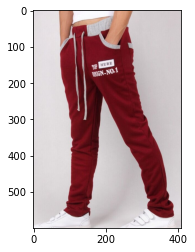

In [7]:
inferer.predict('4138.png')

(1, 'Wedding Dresses', 0.9993426203727722)

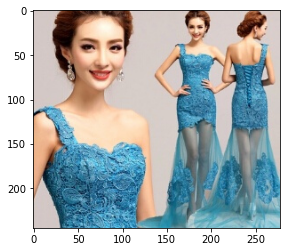

In [8]:
inferer.predict('7732.png')

(1, 'Wedding Dresses', 0.9999889135360718)

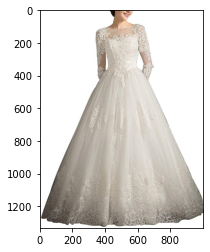

In [9]:
inferer.predict('wd_01.png')

(1, 'Wedding Dresses', 0.9970188140869141)

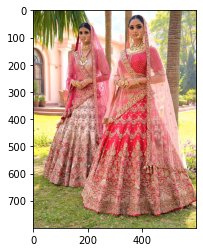

In [10]:
inferer.predict('wd_02.png')

(0, 'Athletic Pants', 4.192158442606342e-08)

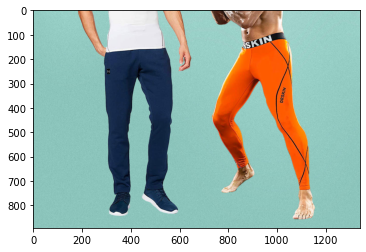

In [11]:
inferer.predict('at_01.png')

(0, 'Athletic Pants', 0.0004394623974803835)

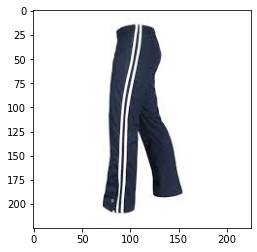

In [12]:
inferer.predict('at_02.png')